# Machine Learning Tutorial 

This tutorial is intended to illustrate a typical workflow for machine learning to solve a land use and land cover classification problem.


Land Use and Land Cover classifications are used to identify the dominant land cover or land use type in an area. We use the Naive Bayes and Random Forest classifiers, as implemented within `scikit-learn` library. This tutorial borrows heavily from the very helpful [tutorial](http://patrickgray.me/open-geo-tutorial/chapter_5_classification.html) developed by Chris Holden and updated by Patrick Gray. Also used: `rasterio`, `geopandas`, `numpy`, `pandas`, `shapely`, and `matplotlib`.

## The Challenge

Our client required a rapid approach for evaluating the benefits of conservation projects to Mule Deer. We proposed using Ecological State and Transition Models (STMs) as the basis for the evaluation. The NRCS has developed STMs for the dominant ecological sites within the region, however only a subset of the region was mapped. We use vegetation data (provided by the [Rangelands App](rangelands.app)) and other environmental variables to predict STM for the unmapped areas of the range.   

### Import Statements

In [1]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

import geopandas as gpd
import numpy as np
from shapely.geometry import mapping
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

import matplotlib.pyplot as plt

# ipywidgets is used to create a progress bar
from ipywidgets import IntProgress
from IPython.display import display

In [2]:
%matplotlib inline

## Import Data

We'll be using supervised classification techniques. We'll need both labels and predictor features to train the models. Our labels will come from the mapped STM derived from NRCS data. To begin, we'll use vegetation data as predictors, including cover estimates for trees, shrubs, perennial grasses and forbs, and bare ground.

In [3]:
# CHANGE TO VEG_COVER_PATH 
# Read in features and training data
train_path = r'D:\ArcGIS\Colorado\General\Rangelands_App\for-analysis\train_clip_utm.tif'
data = rasterio.open(train_path)
data.crs  # Check the projection, all features must share a projection

CRS.from_dict(init='epsg:26913')

In [4]:
labels_path = r'D:\ArcGIS\Colorado\General\Rangelands_App\for-analysis\labels.shp'
labels = gpd.read_file(labels_path)
labels.crs

{'init': 'epsg:26913'}

In [5]:
len(labels)

6136

We have 6,136 labeled polygons, represented within a geopandas dataframe, while our predictor features are represented in a rasterio raster. Both share the same projection.

## Explore Data and Preparation Steps

To train the classifiers, we'll need to associate our vector data (labels as polygons) with our raster pixels (predictor features). We'll accomplish this with the rasterio mask function. The mask function will essentially clip (or mask) our raster with each polygon. First, we'll want to extract the geometry of each feature in the labels shapefile to GeoJSON format.

In [6]:
# this generates a list of shapely geometries
geoms = labels.geometry.values 

# let's grab a single shapely geometry to check
geometry = geoms[0]
print("This is a shapely polygon")
print(type(geometry))
print(geometry)

# transform to GeoJSON format (note 'mapping' is in the shapely namespace)
feature = [mapping(geometry)]  # can also do this using polygon.__geo_interface__
print("This is the same polygon in GeoJSON format")
print(type(feature))
print(feature)

This is a shapely polygon
<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((155090.8039999995 4317864.1029, 155095.9642000003 4317847.2246, 155096.9452999998 4317767.406400001, 155079.9972999999 4317764.4924, 155013.6201999998 4317772.8774, 154946.0262000002 4317762.761399999, 154906.4253000002 4317765.351500001, 154878.2922999999 4317781.742900001, 154874.5252 4317788.509099999, 154877.2857999997 4317829.973099999, 154890.6249000002 4317873.230799999, 154892.2852999996 4317898.202400001, 154873.1852000002 4318020.8462, 154866.6454999996 4318032.8059, 154861.3509 4318094.8554, 154880.1355999997 4318314.824999999, 154876.2439000001 4318350.6874, 154879.5504999999 4318400.631100001, 154884.4243000001 4318410.842, 154890.0175999999 4318527.3519, 154897.2582 4318573.0209, 154890.3213 4318594.527100001, 154894.7226999998 4318598.269300001, 154913.1912000002 4318593.0416, 154946.1224999996 4318553.260600001, 154952.6897 4318463.052999999, 154967.4232000001 4318401.3926, 154951.2766000004 

Now let's extract the raster values within each polygon using the [rasterio mask() function](https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html).

In [7]:
out_image, out_transform = mask(data, feature, crop=True)

In [8]:
out_image.shape

(6, 32, 10)

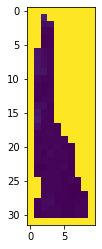

In [9]:
show(out_image[0])

As you can see, the features raster was clipped to a single polygon. There are 6 bands and 32x10 pixels. We'll repeat this process for all 6,136 polygons to build our dataset. We'll also need to clean this raster up a bit before we use it in training. We'll explore all of this next. 

But first, we'll be doing a lot of memory intensive work so we'll close the dataset for now.

In [10]:
data.close()

## Build the Training Data for `sckit-learn`

We'll repeat the above process for all features in the shapefile and create an array `X` that has all the pixels and an array `y` that has all the training labels.

Note that the column 'MuleDeer_1' in the labels geodataframe has the label we're after.
TODO: change to column with label instead of numeric.

In [12]:
%%time
# Lets create a progress bar as this step can take some time
p_bar = IntProgress(min=0, max=len(geoms), description='Processing')
display(p_bar)

# Set up arrays
X = np.array([], dtype=np.int8).reshape(0,6)  # pixels for training
y = np.array([], dtype=np.string_)  # labels for training

# extract the raster values within the polygon
with rasterio.open(train_path) as src:
    band_count = src.count
    for index, geom in enumerate(geoms):  # Note geoms was created above
        feature = [mapping(geom)]
        
        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True)
        # eliminate all the pixels with 0 values for all bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:, ~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all bands  - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:, ~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y, [labels["MuleDeer_1"][index]] * out_image_reshaped.shape[0]) # ???
        # stack the pixels onto the pixel array
        X = np.vstack((X, out_image_reshaped))
        # increment the progress bar
        p_bar.value +=1


IntProgress(value=0, description='Processing', max=6136)

Wall time: 25min 33s


#### Save the output
We'll save the output as a numpy array to avoid the long process of rebuilding the features in the future. This will also allow us to share this analysis with others without them needing access to the input data. If this were not a tutorial, I might have ended the notebook here and started a new one for the remainder of the analysis.

I've commented out the load statements below, uncomment to load in the saved features and labels.

In [13]:
# Save features and labels
np.save('E:/lulc-features.npy', X)
np.save('E:/lulc-labels.npy', y)

In [4]:
# Load in data
X = np.load('E:/lulc-features.npy')  # fill in path
y = np.load('E:/lulc-labels.npy')

### Splitting the data for testing

In order to evaluate the accuracy of our model, we'll reserve a subset of the data for testing. The `train_test_split` function allows us to quickly and randomly subset our data for this purpose.

In [5]:
# split out 30% of data for testing. Random state set for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Pairing y with X

Now that we have the image we want to classify (X_train) and the land cover labels (y_train), let's check to make sure they match in size so we can feed them to our models.

In [6]:
st_names = np.unique(y_train)
print('The training data include {n} classes: {classes}\n'.format(n=st_names.size, 
                                                                classes=st_names))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X_train.shape))
print('Our y array is sized: {sz}'.format(sz=y_train.shape))

The training data include 5 classes: ['Encroached Shrub' 'Loamy Bottom' 'P-J' 'Perennial Shrub'
 'Wet/Salt Meadow']

Our X matrix is sized: (4755679, 6)
Our y array is sized: (4755679,)


That looks good. We have 5 classes (i.e., our STM names); 6 predictor features (i.e., the 6 bands in our X matrix, now flattened; and both the X and y array are the same length.

We'll treat these vegetation cover values as spectral signatures, and plot each to make sure they're actually separable since all we're going by in this classification is pixel values.

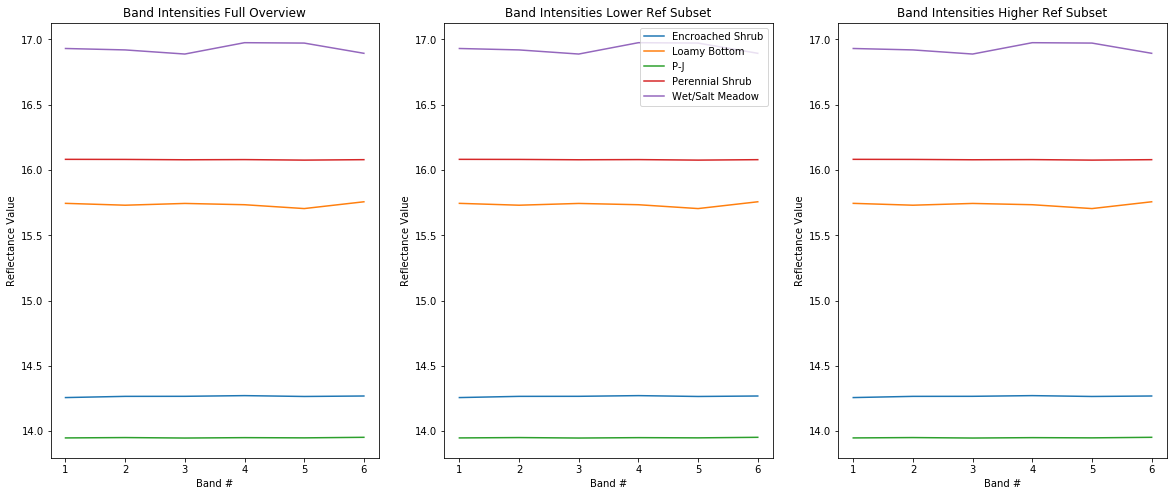

In [11]:
fig, ax = plt.subplots(1, 3, figsize=[20,8])

# bands are numbered 1 through 6 following GDAL convention
band_count = np.arange(1,7)

classes = np.unique(y_train)
for class_type in classes:
    band_intensity = np.mean(X_train[y_train==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=class_type)
    ax[1].plot(band_count, band_intensity, label=class_type)
    ax[2].plot(band_count, band_intensity, label=class_type)
#plot them as lines

# Add some axis labels
# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
ax[1].set_ylabel('Reflectance Value')
ax[1].set_xlabel('Band #')
ax[2].set_ylabel('Reflectance Value')
ax[2].set_xlabel('Band #')
ax[1].legend(loc="upper right")

# Add a title
ax[0].set_title('Band Intensities Full Overview')
ax[1].set_title('Band Intensities Lower Ref Subset')
ax[2].set_title('Band Intensities Higher Ref Subset')

plt.show()

Looks like each class will be easily separable.

This will be a helper function to convert class labels into indices so we're predicting to integers instead of strings.
TODO: switch labels and numbers

In [12]:
def str_class_to_int(class_array):
    class_array[class_array == 'P-J'] = 1
    class_array[class_array == 'Perennial Shrub'] = 2
    class_array[class_array == 'Encroached Shrub'] = 3
    class_array[class_array == 'Loamy Bottom'] = 4
    class_array[class_array == 'Wet/Salt Meadow'] = 5
    return(class_array.astype(int))

## Training the Classifier
Now that we have our X matrix of feature inputs (the vegetation cover bands) and our y array (the labels), we can train our model.

Visit [this web page](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes) to find the usage of GaussianNaiveBayes Classifier from `scikit-learn`.

In [6]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

It's that simple to train a classifier in `sckit-learn`. The hard part is often validation and interpretation.

### Validation

To see how well our classifier worked, we could use the test data we partioned earlier. However, we may want to adjust the model if our results are not as accurate as we'd like. This could lead to overfitting by 'leaking' information from the test set into our training of the model. Overfitting will hurt the performance of our model on predicting novel data, and will lead to inflated accuracy metrics. 

So how do we evaluate our model at this stage? [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html). There are a few options for cross-validation, but for our purposes k-fold cross validation will work. 

In [16]:
# 5-fold cross validation
scores = cross_val_score(gnb, X_train, y_train, cv=5)

`scores` stores the results of computing the score 5 consecutive times (with different splits each time)

In [18]:
scores

array([0.59125447, 0.59230899, 0.59061017, 0.59067851, 0.59257414])

The mean score and the 95% confidence interval of the score estimate are hence given by:

In [19]:
print("Accuracy: %0.2f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.59 (+/- 0.002)


## Improving Model Accuracy

### Standardizing Values

The accuracy is not as good as we'd like. How can we improve the accuracy of the model? One option is to [standardize](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) the data so that each of the features are similar in magnitude. This avoids some higher values from overwhelming lower values. It is often necessary to complete this step, depending on the model used.

`sklearn` provides a `preprocessing` module that facilitate this scaling.

In [8]:
# Hide warnings for converting ints to floats (or save X, y as float64 type)
import warnings
warnings.filterwarnings("ignore")

In [9]:
gnb = make_pipeline(preprocessing.StandardScaler(), GaussianNB())
cross_val_score(gnb, X_train, y_train, cv=5)

array([0.59125447, 0.59230899, 0.59061017, 0.59067851, 0.59257414])

The accuracy is exactly the same! This is because the Gaussian Naive Bayes is robust to scaling. [In essence Gaussian Naive Bayes performs standardization internally](https://stats.stackexchange.com/questions/254723/standardisation-in-naive-bayes/348165).

### Balancing Classes

Unbalanced classes can also impact the accuracy of a model. Imagine you have data on a rare disease that only 0.01% of people have. A simple model that predicts everyone does not have the disease would be right 99.99% of the time! To get a model that can actually predict when people do have the disease, you'll need to address the imbalanced classes.


Again, this is an issue depending on the model used. We'll try a different type of model later in the tutorial that is more robust to imbalanced data (Random Forests). 

To balance the data, you can either down-sample the over-represented classes or up-sample the under-represented classes. 

#### How unbalanced are the classes now?

Let's quickly plot the number of each label so we know how unbalanced the data are.

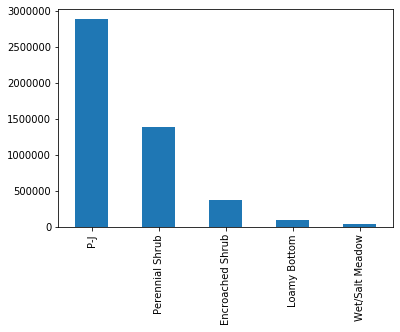

In [10]:
import pandas as pd
df_plot = pd.DataFrame(y_train)
df_plot[0].value_counts().plot(kind='bar')

We'll try up-sampling first so we don't reduce the number of data points too much. How much to upsample? We'll resample each of the less represented features with replacement to get the number of features contained in the most represented class.

In [8]:
df_plot[0].value_counts()

P-J                 2877442
Perennial Shrub     1388305
Encroached Shrub     375820
Loamy Bottom          85357
Wet/Salt Meadow       28755
Name: 0, dtype: int64

This will be easier with a pandas DataFrame, so let's convert our data to a DataFrame.

In [11]:
df = pd.concat(
    [pd.DataFrame(y_train, columns=['label']), 
     pd.DataFrame(X_train)], 
    axis=1
    ).set_index('label')
df.head()

,0,1,2,3,4,5
label,,,,,,
P-J,18,19,12,12,11,13
P-J,9,9,7,8,7,13
P-J,18,24,21,22,20,20
Perennial Shrub,14,18,16,12,14,13
P-J,4,5,9,9,7,7


In [10]:
df_shrub = resample(df.loc['Perennial Shrub'],
                    replace=True,
                    n_samples=df.index.value_counts().max())
df_shrub.shape[0]

2877442

Now we have the same number of Perennial Shrub classes as P-J classes, our dominant class type. Let's repeat for the remaining features. We'll loop through our labels and concatenate the results to the most represented class so that this step is robust to changes in which features we explore.

In [58]:
df.index.value_counts().max()

2877442

In [48]:
# Start by subsetting the most represented class
max_class = df.index.value_counts().idxmax()
df_upsampled = df.loc[max_class]
labels = list(df.index.unique())
labels.remove(max_class)

# For each label, resample the features to balance classes and append
# to the empty dataframe
for label in labels:
    df_temp = resample(
        df.loc[label],
        replace=True,
        n_samples=df.index.value_counts().max()
    )
    df_upsampled = pd.concat([df_upsampled, df_temp], axis=0)
df_upsampled.index.value_counts()

P-J                 2877442
Encroached Shrub    2877442
Perennial Shrub     2877442
Wet/Salt Meadow     2877442
Loamy Bottom        2877442
Name: label, dtype: int64

Now, we can split out our X and y data again and re-train the model on the more balanced classes.

In [61]:
X_train_upsampled = df_upsampled.reset_index().drop('label', axis=1)
y_train_upsampled = df_upsampled.index.values

In [62]:
# 5-fold cross validation
scores = cross_val_score(gnb, X_train_upsampled, 
                         y_train_upsampled, cv=5)
print("Accuracy: %0.2f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.24 (+/- 0.001)


Our accuracy took a bit of a nosedive, as now we're probably over-representing those less common classes on the landscape. For the purposes of our model, it may actually be better to simply ignore those more rare classes instead of over-representing them. We could try downsampling instead, but it will likely not help our accuracy very much. Instead, let's try a different model, Random Forests.

### Alternative Model: Random Forests

Random Forests is robust to unscaled and unbalanced data, making it a good option for this classification problem out-of-the-box. It's not a bad idea to scale the data as we did earlier, but since our data is well scaled (percent cover data from 0 - 100%), we'll skip this step. Acknowledgements to this [tutorial](https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/) used in developing this section.

In [7]:
%%time
from sklearn.ensemble import RandomForestClassifier
# Initialize our model with 10 estimators to limit processing time
rfc = RandomForestClassifier(n_estimators=10, random_state=0)

# 5-fold cross validation
scores = cross_val_score(rfc, X_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.58 (+/- 0.001)
Wall time: 3h 13min 13s


Our accuracy (57%) is slightly less than our accuracy with the unbalanced classes using Naive Bayes (59%) but comparable.

### Confusion Matrix

We can visualize how well we're classifying each class (and where the model is getting confused) using a [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py). The code for the confusion matrix is copied from the linked documentation.

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [10]:
# Use the model to predict on the X_train dataset
y_pred = gnb.fit(X_train, y_train).predict(X_train)

In [11]:
class_names = unique_labels(y_train, y_pred)
np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.00e+00 0.00e+00 8.77e-01 1.22e-01 2.90e-04]
 [0.00e+00 0.00e+00 8.13e-01 1.84e-01 2.91e-03]
 [0.00e+00 0.00e+00 8.86e-01 1.14e-01 8.17e-05]
 [0.00e+00 0.00e+00 8.01e-01 1.89e-01 9.71e-03]
 [0.00e+00 0.00e+00 7.46e-01 2.42e-01 1.17e-02]]


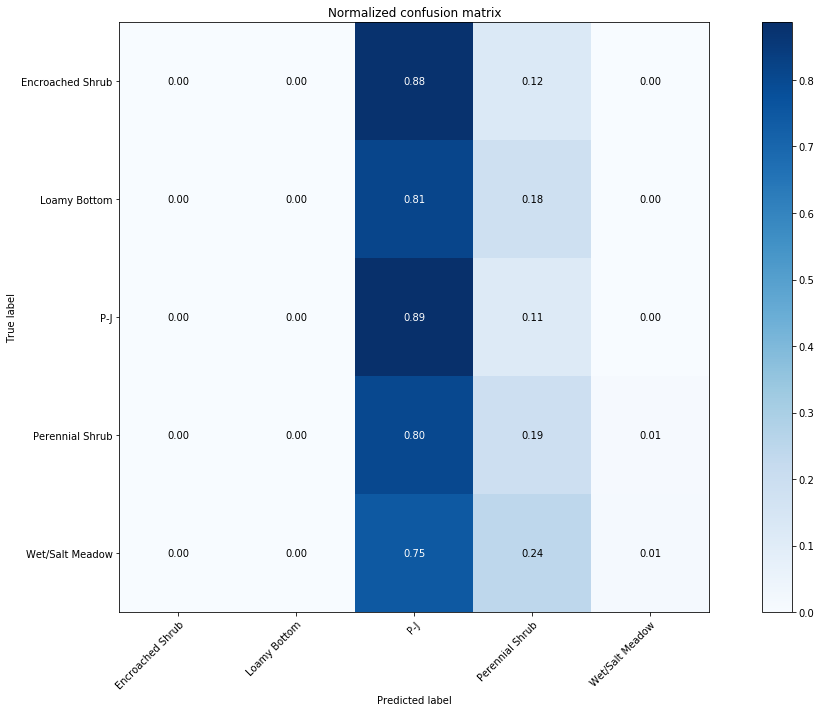

In [44]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_train, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The confusion matrix indicates that the model is catogorizing most pixels as P-J and some as Perennial Shrub, with just a few Wet Meadow predictions. It ignores Encroached Shrub and Loamy Bottom. Focusing on the final row of the matrix, you can see that the Wet/Salt Meadow is being categorized as P-J 75% of the time, Perennial Shrub 24% of the time, and its correct label only 1% of the time.

In [ ]:
y_pred_rfc = rfc.fit(X_train, y_pred).predict(X_train)

Normalized confusion matrix
[[0.00e+00 0.00e+00 8.77e-01 1.22e-01 2.87e-04]
 [0.00e+00 0.00e+00 8.13e-01 1.84e-01 2.85e-03]
 [0.00e+00 0.00e+00 8.86e-01 1.14e-01 8.06e-05]
 [0.00e+00 0.00e+00 8.01e-01 1.89e-01 9.69e-03]
 [0.00e+00 0.00e+00 7.46e-01 2.42e-01 1.17e-02]]


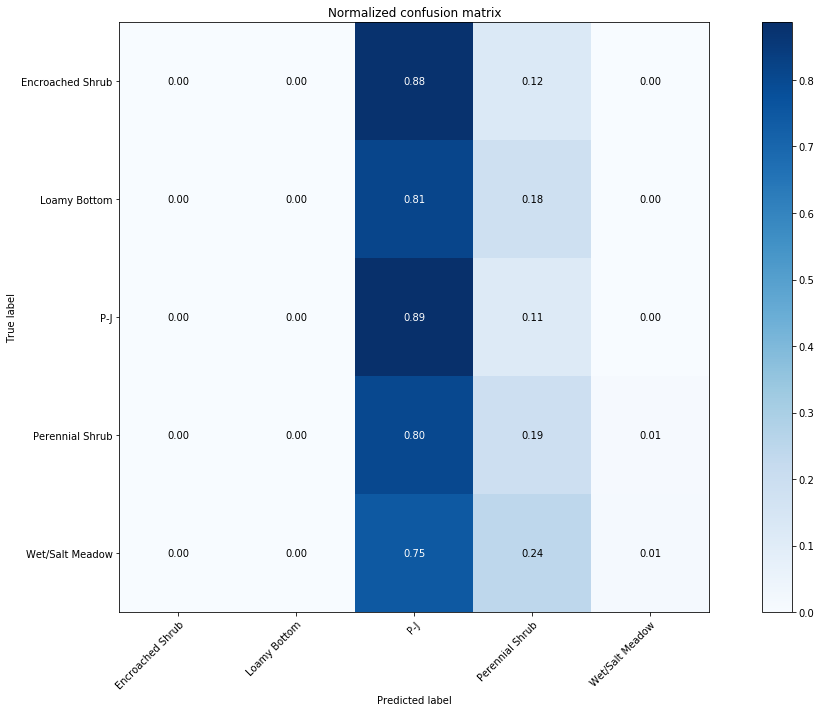

In [48]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_train, y_pred_rfc, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Interestingly, the confusion matrix for both the Naive Bayes and Random Forests model is the same. This may signal that we've done about as well as we could with these features. We could incorporate additional features through the same process as we went through before, considering topography, soils, precipitation, and spatial measures using distances or moving windows. We should also carefully consider feature selection to optimize the bias-variance tradeoffs. Feature engingeering and feature selection is beyond the scope of this tutorial.

A [classification report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report) will provide reportable metrics of model accuracy to allow us document the performance of the model. It reports precision, recall and the F1 score. Precision is the ability of the model to avoid false positives. Recall is the ability to identify the feature correctly (notice it is equivalent to where the diagonal axis of the confusion matrix). The F1 score is a harmonic mean of precision and recall.

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred, target_names=class_names))

C:\Users\Erik\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  precision    recall  f1-score   support

Encroached Shrub       0.00      0.00      0.00    375820
    Loamy Bottom       0.00      0.00      0.00     85357
             P-J       0.62      0.89      0.73   2877442
 Perennial Shrub       0.40      0.19      0.26   1388305
 Wet/Salt Meadow       0.02      0.01      0.02     28755

       micro avg       0.59      0.59      0.59   4755679
       macro avg       0.21      0.22      0.20   4755679
    weighted avg       0.49      0.59      0.52   4755679



## Predicting on the Image

With our classifier fit, we can now proceed by trying to classify the entire image.

In [26]:
range_path = r'D:\ArcGIS\Colorado\General\Rangelands_App\for-analysis\range_clip_utm.tif'
with rasterio.open(range_path) as src:
    profile = src.profile  # the src profile will be used to save the output later
    img = src.read()

# Take our full iamge and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

(6, 9412, 7341)
(9412, 7341, 6)


Now we can predict for each pixel in our image.

In [27]:
class_prediction = gnb.predict(reshaped_img.reshape(-1, 6))

# Reshape our classification map back into a 2d matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

Because we used labels as strings we will want to convert them to numpy array with integers using the helper function we made earlier.

In [31]:
# This function converts the class prediction to ints from strings because it was originally created as a string
# See template notebook for more
class_prediction = str_class_to_int(class_prediction)

### Visualize the Results

First we'll make a colormap so we can adjust the colors of each class to more logical colors. 

In [32]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors

# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (1, (34, 139, 34, 255)),    # Forest Green - PJ
    (2, (139,69,19, 255)),      # Brown - Perennial Shrub
    (3, (48, 156, 214, 255)),   # Blue - Encroached Shrub
    (4, (244, 164, 96, 255)),   # Tan - Loamy Bottom
    (5, (206, 224, 196, 255)),  # Lime - Grass Meadow
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v

index_colors = [colors[key] if key in colors else
               (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

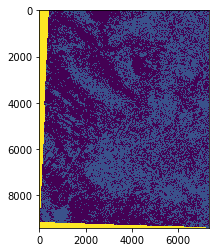

In [33]:
show(class_prediction)

In [35]:
with rasterio.Env():
    
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw')
    
    with rasterio.open(r'D:\ArcGIS\Colorado\General\Rangelands_App\for-analysis\example.tif', 'w', **profile) as dst:
        dst.write(class_prediction.astype(rasterio.uint8), 1)

## Improving our Model Accuracy

In the following sections (TBD), we'll improve upon our model, evaluate accuracy, and explore different classifiers
* Normalize values
* Split into training and testing data
* Balance classes in training data
* Introduce additional features (elevation, precip, soil temperature, aspect, moving window stats, imagery)
* Explore different classifiers
* Feature Importance
* Parameter tuning
* Correlations

[Evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html)

[Accuracy](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score)